# Steps to Tackle a Time Series Problem (with Codes in Python)
Note: These are just the codes from article

## Loading and Handling TS in Pandas

In [1]:
import pandas as pd
import warnings
import xlrd
import sys
from pandas.plotting import register_matplotlib_converters
import numpy as np
from datetime import datetime,timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
import seaborn as sea
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
rcParams['font.sans-serif']=['SimHei']
rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='once')

In [4]:
data = pd.read_excel('k50_education_S_curve.xlsm',encoding="gb18030",sheet_name='学校台区-年-负荷曲线',header=1)
data_industry = pd.read_excel('industry_type.xlsx',encoding="gb18030",header=1)

In [115]:
data = data[data['聚类\n代码']==13]
data.rename(columns={'台区标识':'bs'},inplace=True)
data = data[data.bs.notna()]
data.bs=data.bs.apply(lambda x:x[1:])
data.sort_values(by=['lhrq'],inplace=True)
data.head()

,相似度 分类代码,聚类 代码,聚类 平均误差,bs,台区名称,用户名称,lhrq,学校类型,2017-06-08 00:00:00,2017-06-15 00:00:00,...,2019-03-21 00:00:00,2019-03-28 00:00:00,2019-04-04 00:00:00,2019-04-11 00:00:00,2019-04-18 00:00:00,2019-04-25 00:00:00,2019-05-02 00:00:00,2019-05-09 00:00:00,2019-05-16 00:00:00,2019-05-23 00:00:00
65,16,13,20.76,3000004009,3000004009,深圳第二高级技工学校,2008-01-01,职业技术学院,42.1,88.94,...,394.40,65.34,84.08,408.88,460.66,66.14,75.84,499.32,451.48,527.66
69,16,13,20.76,3000693060,3000693060,深圳市东湖中学,2009-01-31,中学,93.3,84.60,...,426.50,59.70,99.50,431.10,491.20,93.10,97.70,86.70,459.30,71.70
68,16,13,20.76,3000487685,3000487685,深圳市桂园中学,2009-02-02,中学,40.0,49.20,...,504.00,95.00,308.70,549.50,514.20,85.00,508.50,90.20,539.50,84.20
67,16,13,20.76,3000483951,3000483951,深圳市明珠学校,2009-02-02,学校,61.2,61.50,...,365.50,69.70,68.70,347.20,353.00,74.20,361.70,79.50,290.20,84.20
76,16,13,20.76,3002161653,3002161653,深圳市龙岗区横岗街道荷坳小学,2009-02-03,小学,0.0,0.00,...,93.99,7.97,22.70,97.36,8.96,9.59,96.37,89.93,91.90,95.67


In [130]:
print(data)

    相似度\n分类代码  聚类\n代码  聚类\n平均误差                bs                台区名称  \
65         16      13     20.76        3000004009          3000004009   
69         16      13     20.76        3000693060          3000693060   
68         16      13     20.76        3000487685          3000487685   
67         16      13     20.76        3000483951          3000483951   
76         16      13     20.76        3002161653          3002161653   
64         16      13     20.76  2222222223650759          深圳市南山区西丽小学   
71         16      13     20.76        3001502216          3001502216   
70         16      13     20.76        3000839392          3000839392   
75         16      13     20.76        3001760871          3001760871   
66         16      13     20.76        3000483141          3000483141   
72         16      13     20.76        3001595617          3001595617   
73         16      13     20.76        3001639637          3001639637   
74         16      13     20.76        3001726528  

In [116]:
import time
print(data.columns.to_list()[9])
data.insert(8,'age',data.columns.to_list()[9]-data.lhrq)

2017-06-15 00:00:00


In [ ]:

for i in range(data.shape[1]-1):
    for j in range(data.shape[0]-1):
        try:
            if data.iloc[j,i] is None:
                data.iloc[j,i] = (data.iloc[j+1,i]+data.iloc[j-1,i])/2
        except IndexError:
            print(j,i)

In [119]:
import copy
data_increase = copy.deepcopy(data)
for i in range(data_increase.shape[1]-1,9,-1):
    for j in range(0,data_increase.shape[0]):
        try:
            data_increase.iloc[j,i] = (data.iloc[j,i]-data.iloc[j,i-1])/data.iloc[j,i-1]
        except TypeError:
            print(i,j)
            print(data.iloc[j,i-1])

#第一个星期没有增长率数据，去掉
data_increase.drop(columns=data_increase.columns[9],inplace=True)

2017-06-08 00:00:00


In [138]:
data_draw = data.drop(columns=['相似度\n分类代码','聚类\n代码','聚类\n平均误差','台区名称','用户名称','lhrq','学校类型','age'])

data_draw.set_index('bs',inplace=True)
data_draw = data_draw.T
print(data_draw.columns)
print(data_draw.shape[1])

for i in range(data_draw.shape[1]-1):
    for j in range(data_draw.shape[0]-1):
        try:
            if data_draw.iloc[j,i] is None:
                data_draw.iloc[j,i] = (data_draw.iloc[j+1,i]+data_draw.iloc[j-1,i])/2
        except IndexError:
            print(j,i)

Index(['3000004009', '3000693060', '3000487685', '3000483951', '3002161653',
       '2222222223650759', '3001502216', '3000839392', '3001760871',
       '3000483141', '3001595617', '3001639637', '3001726528', '3002806629',
       '3002731289', '3002173802', '3002872988', '3002847750', '3002914801',
       '2222222222915145', '2222222223020130', '2222222223325245',
       '2222222223255285'],
      dtype='object', name='bs')
23


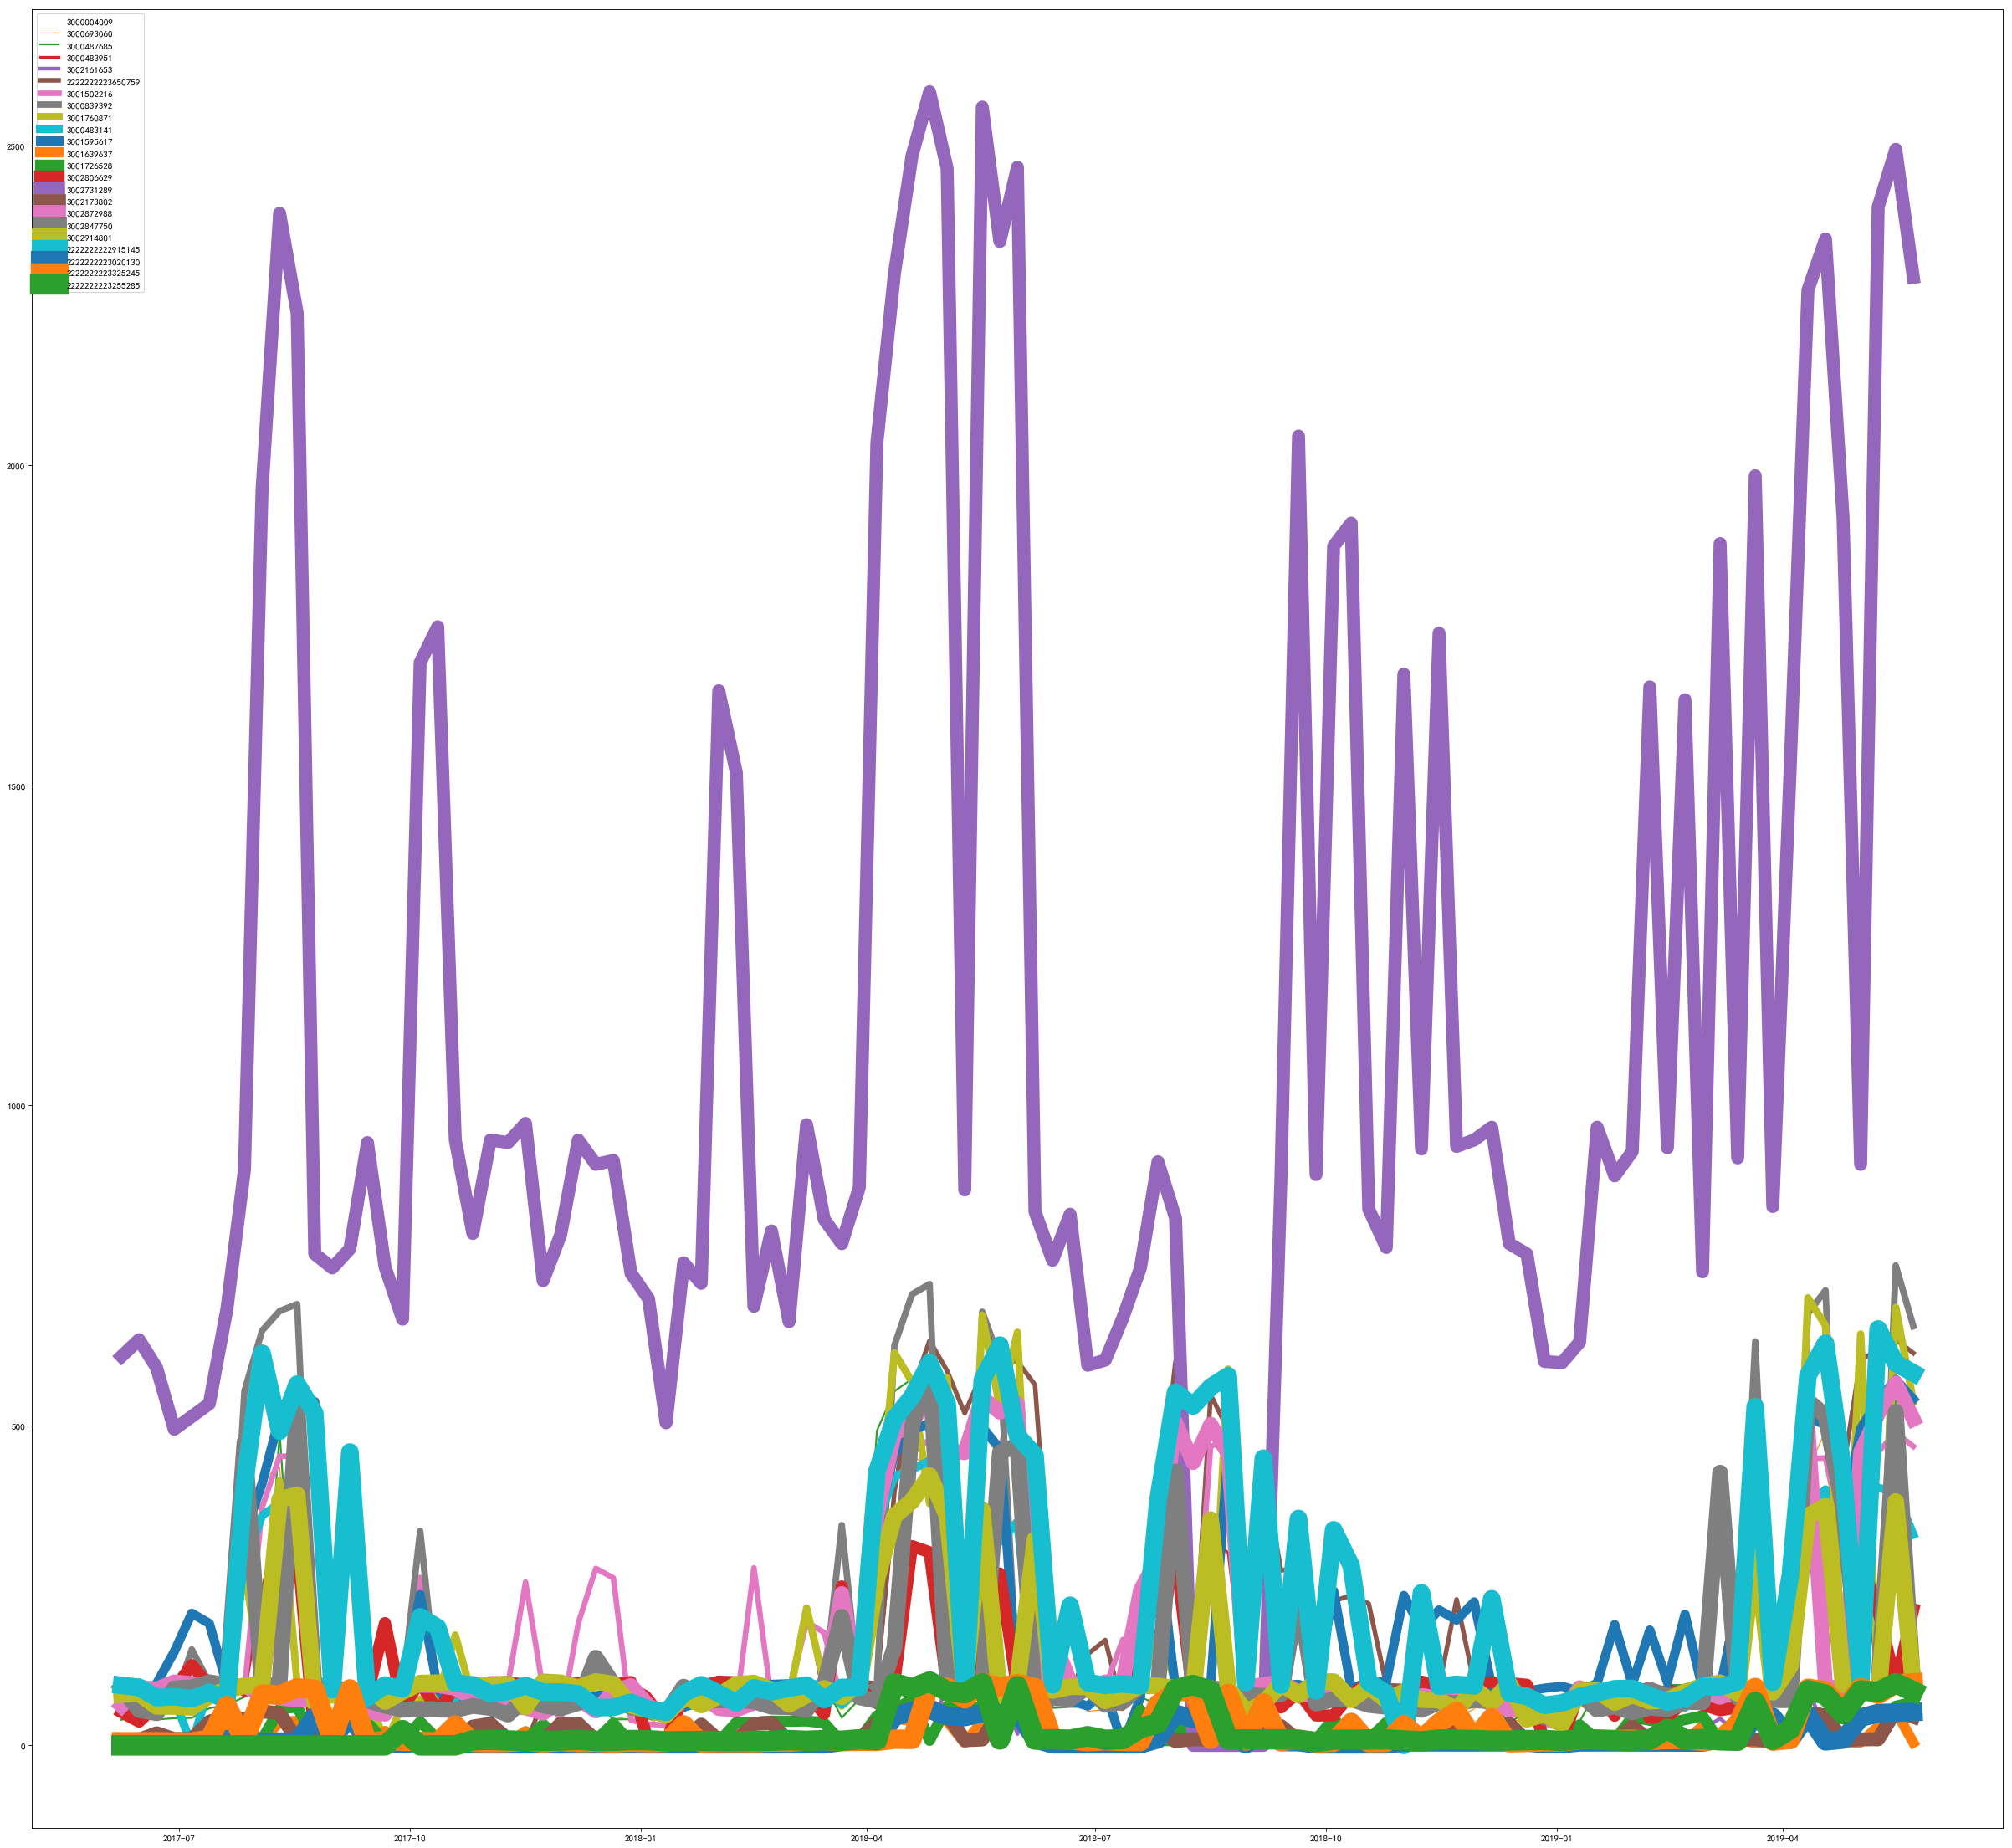

In [139]:
register_matplotlib_converters()
plt.figure(figsize=(38,36), dpi=80)
for i in range(data_draw.shape[1]):
    plt.plot(data_draw.iloc[:,i],label=data_draw.columns[i],linewidth=i)
leg = plt.legend(loc='best')
plt.savefig('data_draw.png')
plt.show()

In [140]:
data_increase_draw = data_increase.drop(columns=['相似度\n分类代码','聚类\n代码','聚类\n平均误差','台区名称','用户名称','lhrq','学校类型','age'])

data_increase_draw.set_index('bs',inplace=True)
data_increase_draw = data_increase_draw.T


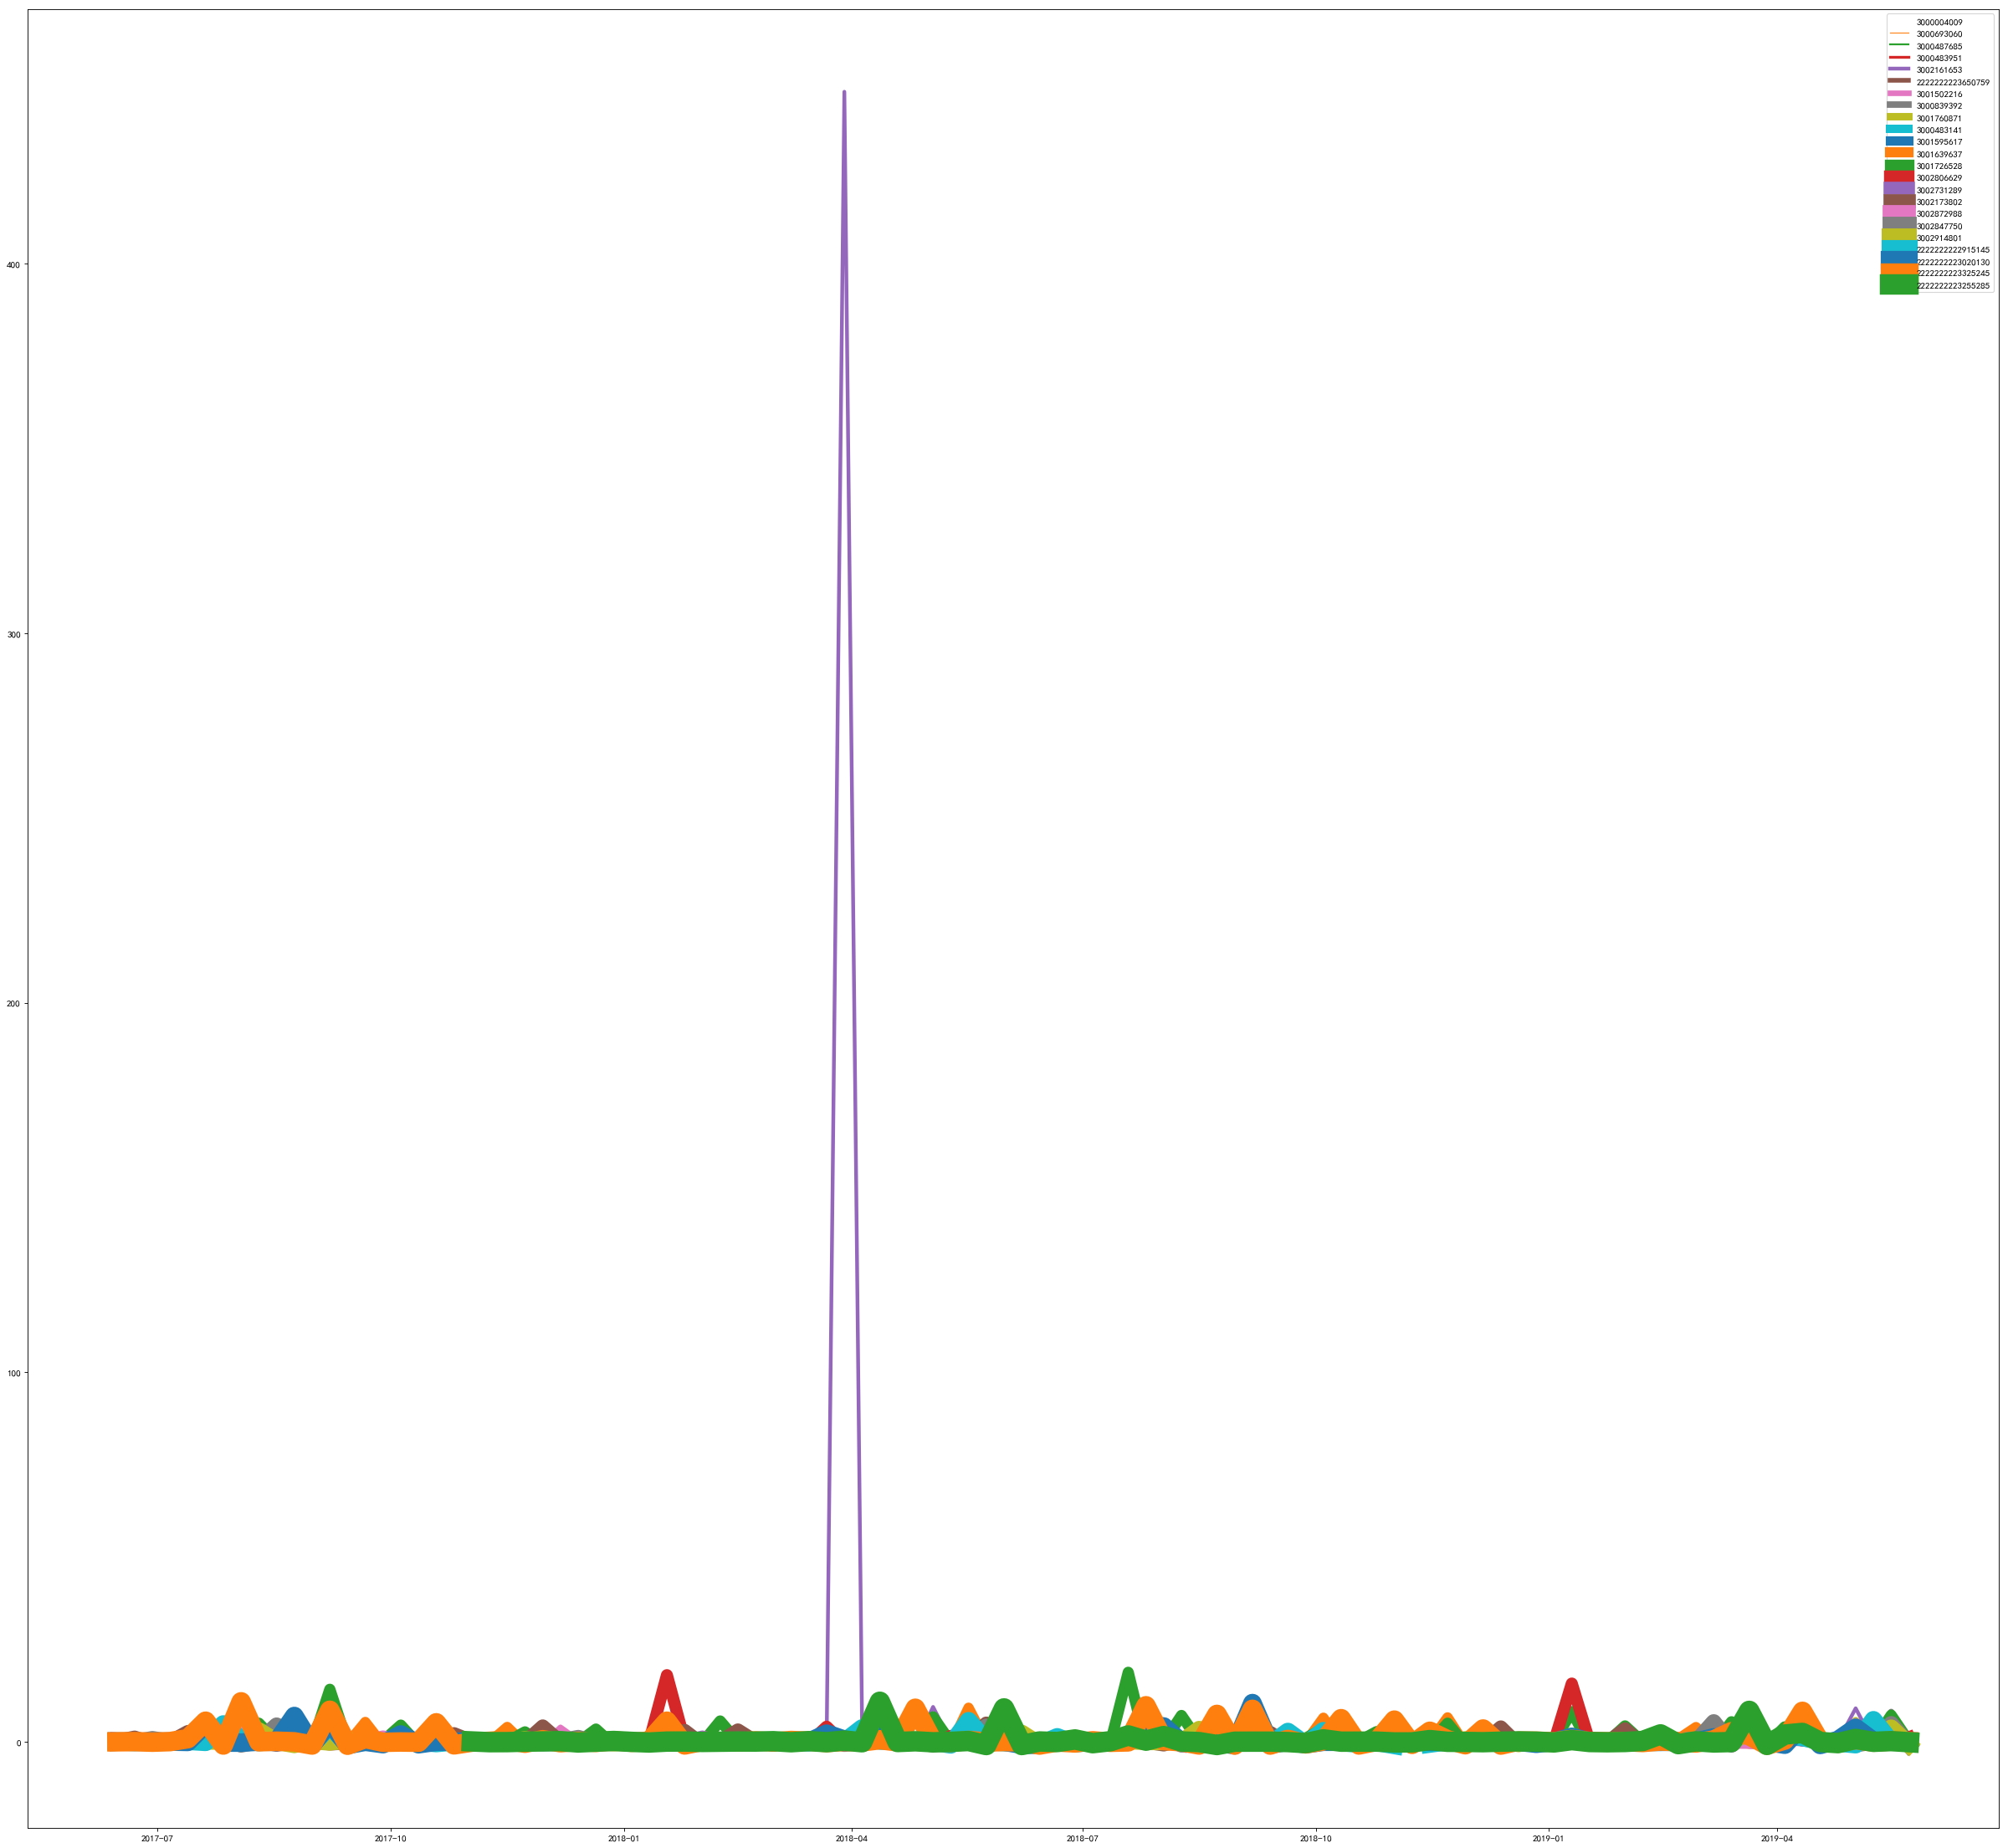

In [141]:
register_matplotlib_converters()
plt.figure(figsize=(38,36), dpi=80)
for i in range(data_draw.shape[1]):
    plt.plot(data_increase_draw.iloc[:,i],label=data_increase_draw.columns[i],linewidth=i)
leg = plt.legend(loc='best')
plt.savefig('data_increase_draw.png')
plt.show()

In [143]:
print(data_increase_draw[['3002161653','2222222223650759','3001760871','3000483141','3001595617','3001726528','3002731289']])

bs          3002161653  2222222223650759  3001760871  3000483141  3001595617  \
2017-06-15         NaN               NaN   -0.068613    0.162130   -0.213933   
2017-06-22         NaN               NaN   -0.028997   -0.101833    0.264314   
2017-06-29         NaN               NaN   -0.104385   -0.170068    0.511787   
2017-07-06         NaN               NaN    0.197657   -1.000000    0.412392   
2017-07-13         NaN               NaN   -0.002257         inf   -0.077571   
2017-07-20         NaN               NaN   -0.099799    0.037037   -0.503307   
2017-07-27         NaN               NaN    2.195755    1.910204    2.479391   
2017-08-03         NaN               NaN   -0.637714    0.258766    0.242938   
2017-08-10         NaN               NaN    3.155330    0.054875    0.254692   
2017-08-17         NaN               NaN   -0.767181    0.013203    0.030969   
2017-08-24         NaN               NaN   -0.074296   -0.740683    0.014736   
2017-08-31         NaN               NaN

In [24]:
data.age=data.age.to_datetime()
data.dtypes

AttributeError: 'Series' object has no attribute 'to_datetime'

In [180]:
year_group = lambda x:x.astype('datetime64[Y]').astype(int) + 1970
lhrq_groupby =data.groupby(data.lhrq.dt.year)

In [181]:
print(lhrq_groupby)

In [162]:
data.dtypes

相似度\n分类代码                       int64
聚类\n代码                          int64
聚类\n平均误差                      float64
bs                             object
台区名称                           object
用户名称                           object
lhrq                   datetime64[ns]
学校类型                           object
2017-06-08 00:00:00           float64
2017-06-15 00:00:00           float64
2017-06-22 00:00:00           float64
2017-06-29 00:00:00           float64
2017-07-06 00:00:00           float64
2017-07-13 00:00:00           float64
2017-07-20 00:00:00           float64
2017-07-27 00:00:00           float64
2017-08-03 00:00:00           float64
2017-08-10 00:00:00           float64
2017-08-17 00:00:00           float64
2017-08-24 00:00:00           float64
2017-08-31 00:00:00           float64
2017-09-07 00:00:00           float64
2017-09-14 00:00:00           float64
2017-09-21 00:00:00           float64
2017-09-28 00:00:00           float64
2017-10-05 00:00:00           float64
2017-10-12 0

In [164]:
year_group = lambda x:x.year
data.lhrq.groupby(data.lhrq.year)

AttributeError: 'Series' object has no attribute 'year'

In [105]:
# 删除含有负值和零值的行
# datatemp=data.drop(columns=['tqlx','tqmc','bs'])
# droplist=[]
# for i in range(len(datatemp.index)):
#     if (datatemp.iloc[i].values<=np.array(0)).any():
#         droplist.append(datatemp.iloc[i].name)
# data=data.drop(labels=droplist)
# data.head()

In [106]:
# datatemp=data.drop(columns=['tqlx','tqmc','bs'])
# print((datatemp.index.isin([0])).size)
# datatemp[datatemp.index.isin([0])]

In [107]:
#每一行的空值用每一行的平均值来填充
# for row in data.index:
#     data.loc[row].fillna(data.loc[row].drop(['tqlx','tqmc','bs']).mean(),inplace=True)
# data.head()

In [109]:
#tqlx和tqmc在时间序列分析中暂时用不到，删除
# data.tqmc.str.contains('学校|大学|小学|中学')
# data.loc[data.tqmc.str.contains('学校|大学|小学|中学',na=False)]
import copy
data_time_series = copy.deepcopy(data.drop(columns=['相似度\n分类代码','聚类\n代码','聚类\n平均误差','台区名称','用户名称']))
data_time_series.reset_index(inplace=True)
data_time_series.head()

,bs,2017/6/8,2017/6/15,2017/6/22,2017/6/29,2017/7/6,2017/7/13,2017/7/20,2017/7/27,2017/8/3,...,2019/3/21,2019/3/28,2019/4/4,2019/4/11,2019/4/18,2019/4/25,2019/5/2,2019/5/9,2019/5/16,2019/5/23
0,3000004009,42.1,88.94,99.44,95.24,129.48,95.18,68.6,88.96,284.52,...,394.4,65.34,84.08,408.88,460.66,66.14,75.84,499.32,451.48,527.66
1,3000483141,84.5,98.20,88.20,73.20,0.00,94.50,98.0,285.20,359.00,...,350.0,67.50,192.70,373.50,400.00,93.70,376.20,402.50,395.70,329.50
2,3000483951,61.2,61.50,58.50,86.50,84.70,93.00,94.7,77.20,244.00,...,365.5,69.70,68.70,347.20,353.00,74.20,361.70,79.50,290.20,84.20
3,3000487685,40.0,49.20,40.50,42.50,43.00,58.00,63.5,75.70,88.70,...,504.0,95.00,308.70,549.50,514.20,85.00,508.50,90.20,539.50,84.20
4,3000693060,93.3,84.60,73.30,58.30,67.20,73.30,91.9,98.00,415.70,...,426.5,59.70,99.50,431.10,491.20,93.10,97.70,86.70,459.30,71.70


In [110]:
#转置
data_time_series=data_time_series.T
#把标识行设为列名
data_time_series.columns = data_time_series.iloc[0]
data_time_series.drop(index='bs',inplace=True)
data_time_series.head()

bs,3000004009,3000483141,3000483951,3000487685,3000693060,3000839392,3001502216,3001595617,3001639637,3001726528,...,3002731289,3002806629,3002847750,3002872988,3002914801,2222222223650759,2222222222915145,2222222223325245,2222222223255285,2222222223020130
2017/6/8,42.1,84.5,61.2,40,93.3,92.1,60.45,97.32,7.116,5.468,...,608,51.9,89.8,61.7,79.5,NaN,93.9,5.68,NaN,1.68
2017/6/15,88.94,98.2,61.5,49.2,84.6,95.25,63.6,76.5,8.18,4.192,...,634,37.1,55.4,90.7,81.3,NaN,90.6,5.6,NaN,1.76
2017/6/22,99.44,88.2,58.5,40.5,73.3,72.3,51.3,96.72,7.432,3.944,...,590,63.2,50.4,88.2,60.9,NaN,74.7,5.76,NaN,1.76
2017/6/29,95.24,73.2,86.5,42.5,58.3,69.6,65.1,146.22,5.5,3.544,...,494,88.85,89,99.3,60.9,NaN,76.2,5.04,NaN,1.68
2017/7/6,129.48,0,84.7,43,67.2,150,70.65,206.52,10.224,6.004,...,514,125.5,90.8,96.7,59.4,NaN,73.2,5.2,NaN,1.76


In [111]:
#将索引变为列，方便之后格式转换
data_time_series.index.names=['time_series']
data_time_series=data_time_series.reset_index()
data_time_series.head()

bs,time_series,3000004009,3000483141,3000483951,3000487685,3000693060,3000839392,3001502216,3001595617,3001639637,...,3002731289,3002806629,3002847750,3002872988,3002914801,2222222223650759,2222222222915145,2222222223325245,2222222223255285,2222222223020130
0,2017/6/8,42.1,84.5,61.2,40,93.3,92.1,60.45,97.32,7.116,...,608,51.9,89.8,61.7,79.5,NaN,93.9,5.68,NaN,1.68
1,2017/6/15,88.94,98.2,61.5,49.2,84.6,95.25,63.6,76.5,8.18,...,634,37.1,55.4,90.7,81.3,NaN,90.6,5.6,NaN,1.76
2,2017/6/22,99.44,88.2,58.5,40.5,73.3,72.3,51.3,96.72,7.432,...,590,63.2,50.4,88.2,60.9,NaN,74.7,5.76,NaN,1.76
3,2017/6/29,95.24,73.2,86.5,42.5,58.3,69.6,65.1,146.22,5.5,...,494,88.85,89,99.3,60.9,NaN,76.2,5.04,NaN,1.68
4,2017/7/6,129.48,0,84.7,43,67.2,150,70.65,206.52,10.224,...,514,125.5,90.8,96.7,59.4,NaN,73.2,5.2,NaN,1.76


Reading as datetime format:

In [112]:
#将含有时序数据的字段转化为datetime64格式
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y/%m/%d')
# dateparse('2017-08-01')
data_time_series['time_series'] = data_time_series['time_series'].apply(dateparse)
data_time_series.set_index('time_series',inplace=True)
data_time_series=data_time_series.apply(pd.to_numeric)
data_time_series.head()

bs,3000004009,3000483141,3000483951,3000487685,3000693060,3000839392,3001502216,3001595617,3001639637,3001726528,...,3002731289,3002806629,3002847750,3002872988,3002914801,2222222223650759,2222222222915145,2222222223325245,2222222223255285,2222222223020130
time_series,,,,,,,,,,,,,,,,,,,,,
2017-06-08,42.10,84.5,61.2,40.0,93.3,92.10,60.45,97.32,7.116,5.468,...,608.0,51.90,89.8,61.7,79.5,NaN,93.9,5.68,NaN,1.68
2017-06-15,88.94,98.2,61.5,49.2,84.6,95.25,63.60,76.50,8.180,4.192,...,634.0,37.10,55.4,90.7,81.3,NaN,90.6,5.60,NaN,1.76
2017-06-22,99.44,88.2,58.5,40.5,73.3,72.30,51.30,96.72,7.432,3.944,...,590.0,63.20,50.4,88.2,60.9,NaN,74.7,5.76,NaN,1.76
2017-06-29,95.24,73.2,86.5,42.5,58.3,69.60,65.10,146.22,5.500,3.544,...,494.0,88.85,89.0,99.3,60.9,NaN,76.2,5.04,NaN,1.68
2017-07-06,129.48,0.0,84.7,43.0,67.2,150.00,70.65,206.52,10.224,6.004,...,514.0,125.50,90.8,96.7,59.4,NaN,73.2,5.20,NaN,1.76


In [113]:
#处理空值
# data_time_series=data_time_series.fillna(method='backfill',axis='index')
# data_time_series_dropna=data_time_series.dropna(axis='columns')
#去掉重复的台区（重复列）
# data_time_series_dropna=data_time_series_dropna.T.drop_duplicates().T
# data_time_series_dropna.index

In [114]:
#粗筛出原始数据缺失值比较少的台区（其表现为填充空值操作后连续重复值较少）,保存为一个列表
# drop_little_tq_index = data_time_series_dropna.T\
# [data_time_series_dropna.T['2017-06-08']!=data_time_series_dropna.T['2017-08-03']].index.to_list()

In [115]:
# print(data_time_series_dropna.columns.is_unique)
#打印列的重复次数
# List=data_time_series_dropna.columns.to_list()
# List_set = set(List) 
# for item in List_set:
#     if List.count(item)>1:
#         print("the %s has found %d" %(item,List.count(item)))

In [116]:
# data_2017_max=pd.DataFrame(data_time_series_dropna['2017'].max(),columns=['2017'])
# data_2018_max=pd.DataFrame(data_time_series_dropna['2018'].max(),columns=['2018'])
# data_2019_max=pd.DataFrame(data_time_series_dropna['2019'].max(),columns=['2019'])

# print(data_2017_max.head())

# print(type(data_2017_max))
# print(data_2017_max.head())
# data_2017_max.index.is_unique

In [117]:
# bs_year_max=pd.concat([data_2017_max,data_2018_max,data_2019_max],axis=1,join='inner')
# bs_year_max.index.is_unique

In [118]:
#粗筛出逐年增长的负荷数据
# increase_tq_index = bs_year_max[(bs_year_max['2017']<bs_year_max['2018']) & (bs_year_max['2018']<bs_year_max['2019'])].index.to_list()

In [119]:
#打印出既是逐年增长也没有太多缺失值的台区
# intersection_index = list(set(drop_little_tq_index).intersection(set(increase_tq_index)))
# print(intersection_index)

In [18]:
#convert to time series:
ts = data_time_series_dropna[3002232277]
ts.head()

time_series
2017-06-08    5.242
2017-06-15    5.242
2017-06-22    5.242
2017-06-29    5.242
2017-07-06    5.486
Name: 3002232277, dtype: float64

# 平稳性检验

## 展示时序图

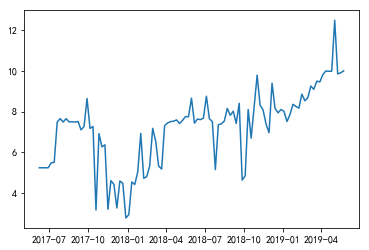

In [19]:
register_matplotlib_converters()
plt.plot(ts)

### 平稳性检验函数

In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #移动平均和移动方差
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #把移动平均和移动方差画出来:
    orig = plt.plot(timeseries, color='blue',label='原始曲线')
    mean = plt.plot(rolmean, color='yellow', label='移动平均')
    std = plt.plot(rolstd, color='black', label = '移动方差')
    plt.legend(loc='best')
    plt.title(u'绘制移动平均数和移动方差，观察它是否随着时间变化')
    plt.show(block=False)
    
    #进行单位根检验:
    print('单位根检验:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput.loc['p-value']>0.01:
        print('p值大于0.01，不能拒绝原假设，说明时间序列是非平稳的')
    else:
        print('p值小于0.01，拒绝原假设，说明时间序列是平稳的')
    return dfoutput.loc['p-value']<0.01
    #返回时间序列是否平稳的判断值
    '''
    单位根的原假设为序列具有单位根，即非平稳，
    对于一个平稳的时序数据，就需要在给定的置信水平上显著，拒绝原假设。
    '''

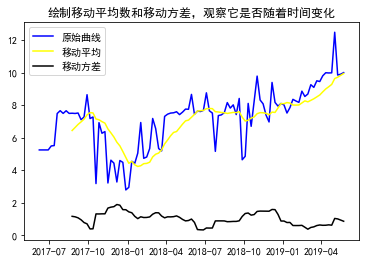

单位根检验:
Test Statistic                 -1.379427
p-value                         0.592099
#Lags Used                      3.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64
p值大于0.01，不能拒绝原假设，说明时间序列是非平稳的


False

In [21]:
test_stationarity(ts)

# 平稳性的处理


## 预测和消除趋势


## Smoothing:

### 移动平均

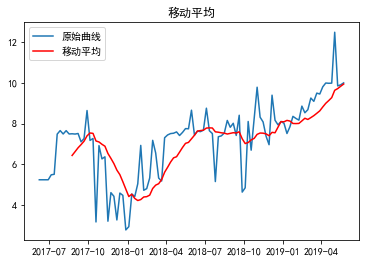

In [22]:
moving_avg = ts.rolling(12).mean()
plt.plot(ts,label='原始曲线')
plt.plot(moving_avg, color='red',label='移动平均')
plt.title('移动平均')
plt.legend(loc='best')
plt.show()

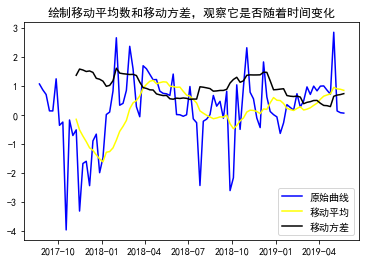

单位根检验:
Test Statistic                 -3.350327
p-value                         0.012773
#Lags Used                      2.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64
p值大于0.01，不能拒绝原假设，说明时间序列是非平稳的


False

In [23]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_moving_avg_diff)

### 指数平滑法

In [24]:
# expwighted_avg = ts.ewm(halflife=12).mean()
# plt.plot(ts,label='原始曲线')
# plt.plot(expwighted_avg, color='red',label='指数平滑曲线')
# plt.title('指数平滑处理')
# plt.legend(loc='best')
# plt.show()
#expwighted_avg.plot(style='k--')

In [25]:
# ts_ewma_diff = ts - expwighted_avg
# test_stationarity(ts_ewma_diff)

## 消除趋势和季节性

### 差分:

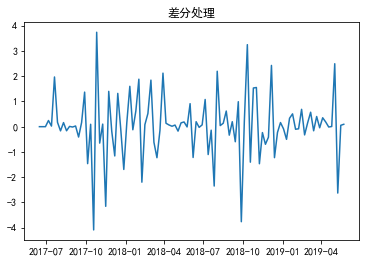

In [26]:
#直接对原始数据取一阶差分:
ts_diff = ts - ts.shift(1)
plt.plot(ts_diff)
plt.title('差分处理')
plt.show()

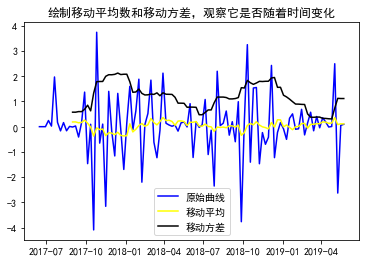

单位根检验:
Test Statistic                -8.570583e+00
p-value                        8.218573e-14
#Lags Used                     2.000000e+00
Number of Observations Used    9.900000e+01
Critical Value (1%)           -3.498198e+00
Critical Value (5%)           -2.891208e+00
Critical Value (10%)          -2.582596e+00
dtype: float64
p值小于0.01，拒绝原假设，说明时间序列是平稳的


True

In [27]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

# 构建模型

## 时间序列的分解（分解后分开预测）

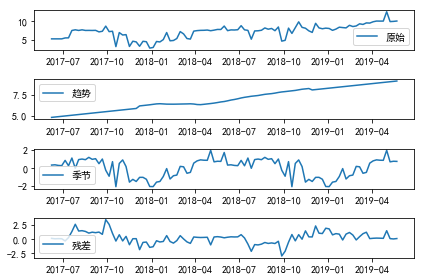

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts,extrapolate_trend='freq')
# 显式调用seasonal_decompose函数的extrapolate_trend参数可以强制提取残差，同时使趋势曲线更加平滑
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='原始')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='趋势')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='季节')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='残差')
plt.legend(loc='best')
plt.tight_layout()

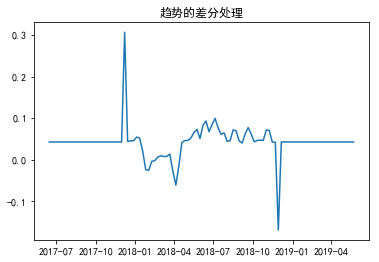

In [29]:
trend_diff = trend - trend.shift(1)
plt.plot(trend_diff)
plt.title('趋势的差分处理')
plt.show()

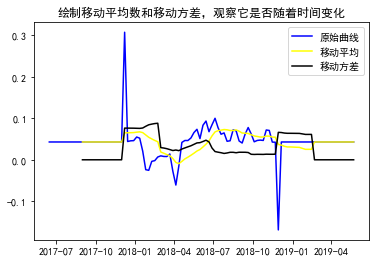

单位根检验:
Test Statistic                -7.485898e+00
p-value                        4.640161e-11
#Lags Used                     0.000000e+00
Number of Observations Used    1.010000e+02
Critical Value (1%)           -3.496818e+00
Critical Value (5%)           -2.890611e+00
Critical Value (10%)          -2.582277e+00
dtype: float64
p值小于0.01，拒绝原假设，说明时间序列是平稳的


True

In [30]:
trend_diff.dropna(inplace=True)
test_stationarity(trend_diff)

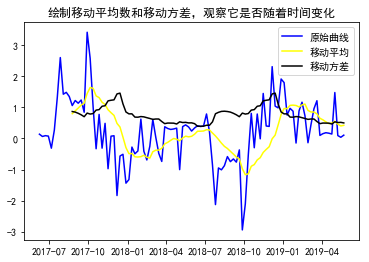

单位根检验:
Test Statistic                 -4.022707
p-value                         0.001296
#Lags Used                     12.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64
p值小于0.01，拒绝原假设，说明时间序列是平稳的


True

In [31]:
ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)

## 利用交叉验证法求预测模型参数

# 创建训练集和测试集
size = int(len(ts_diff) * 0.8)
train, test = ts_diff[0:size], ts_diff[size:len(ts_diff)]
register_matplotlib_converters()
plt.plot(train.index, train, color='blue', label='训练集')
plt.plot(test.index, test, color='green', label='测试集')
plt.legend()
plt.title('真实数据的训练集和测试集')
plt.show()

#样本内预测的结果和预测误差
def compare_ARIMA_modes_testing(order):
    history = [x for x in train]
    predictions_f = list()
    predictions_p = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=-1)
        yhat_f = model_fit.forecast()[0][0]
        yhat_p = model_fit.predict(start=len(history), end=len(history))[0]
        predictions_f.append(yhat_f)
        predictions_p.append(yhat_p)
        history.append(test[t])
    #mean_squared_error即为“误差”的平方的期望值
    error_f = mean_squared_error(test, predictions_f)
    error_p = mean_squared_error(test, predictions_p)
    print('MSE forecast:\t\t\t{:1.4f}'.format(error_f))
    print('MSE predict:\t\t\t{:1.4f}'.format(error_p))
    return {'Predictions forecast': pd.Series(predictions_f,index=test.index),
            'Predictions predict': pd.Series(predictions_p,index=test.index),
            'MSE forecast': error_f,
            'MSE predict': error_p}

#利用交叉验证法寻找最佳阶数
def cross_proper_model(maxLag):
    init_error = sys.maxsize
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            arima = compare_ARIMA_modes_testing((p,1,q))
            error_f = arima['MSE forecast']
            error_p = arima['MSE predict']
        if error_f < init_error or error_p < init_error:
                init_p = p
                init_q = q
                init_properModel =arima
                init_error = min(error_f,error_p)
    return [init_error, init_p, init_q, init_properModel]

## 利用贝叶斯信息准则求预测模型参数

In [32]:
#利用贝叶斯信息准则（BIC）寻找最佳阶数，使得BIC达到最小值的(p, q)即为该准则下的最优模型的阶数
def proper_model(data_ts, maxLag):
    init_bic = sys.maxsize
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(data_ts, order=(p, q),freq=data_ts.index.inferred_freq)
            try:
                results_ARMA = model.fit(disp=-1, method='css')
            except:
                continue#忽略所有异常
            bic = results_ARMA.bic
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARMA
                init_bic = bic
    return [init_bic, init_p, init_q, init_properModel]

## 预测模型（针对趋势和残差）

In [33]:
#样本外预测
def compare_ARIMA_modes(series,order):
    history_f = [x for x in series]
    history_p = [x for x in series]
    series_p = series
    series_f = series
#     for t in range(52):滚动预测的效果不佳
    model = ARIMA(history_f, order=order)
    model_fit = model.fit(disp=-1)
    yhat_f = model_fit.forecast(steps=104)[0]
    model = ARIMA(history_p, order=order)
    model_fit = model.fit(disp=-1)
    yhat_p = model_fit.predict(start=len(history_p), end=len(history_p)+104)
    
    #附加新元素时也加上一个单位的索引
    for t in range(104,1,-1):
        series_p = series_p.append(pd.Series(yhat_p[-t],index=[series_p.index[-1]+timedelta(days=7)]))
        series_f = series_f.append(pd.Series(yhat_f[-t],index=[series_f.index[-1]+timedelta(days=7)]))
    return {'Predictions forecast': series_f[series.index[-1]:series_f.index[-1]],
            'Predictions predict': series_p[series.index[-1]:series_p.index[-1]]}

In [34]:
#样本外预测
def LinearRegression_modes(series):
    history = [x for x in series]
    series_p = series
    #lr = LassoCV(cv=tscv)
    lr = LinearRegression(normalize= "l1") 
    #可以尝试随机森林的效果，也不错。也可以做多模型结果融合，请自己尝试。
    #lr = RandomForestRegressor(n_estimators=100, max_depth=10) #lag_start = 288, lag_end = 320
    # lr = RidgeCV(cv = tscv)
    lr.fit(np.array(range(len(series.index))).reshape(1, -1), np.array(series.values).reshape(1, -1))
    #train_score = lr.score(x_train_scaled, y_train)
    #test_score = lr.score(x_test_scaled, y_test)
    #print("num_tree", each, "score", train_score, test_score)
    #print(x_pred)
    # now 拟合
    print(np.array(range(len(series.index))).reshape(1, -1))
    y_fit = lr.predict(np.array(range(len(series.index),len(series.index)+103)).reshape(1, -1))
    print(y_fit[0])
    print(series.values)
    #附加新元素时也加上一个单位的索引
    for t in range(52,1,-1):
        series_p = series_p.append(pd.Series(y_fit[0][-t],index=[series_p.index[-1]+timedelta(days=7)]))
    return {'Predictions': series_p[series.index[-1]:series_p.index[-1]]}

In [35]:
#季节变动每一年都是一样的，预测季节因素只需要将前一年的数据复制到新一年即可
def season_forcast_year(seasonal):
    seasonal_f = seasonal
    seasonal_f.index = seasonal.index+timedelta(weeks=104)
    return seasonal_f

In [36]:
linear_predict = LinearRegression_modes(trend)

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
   36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
   72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
   90  91  92  93  94  95  96  97  98  99 100 101 102]]
[4.78194349 4.82478953 4.86763556 4.9104816  4.95332763 4.99617367
 5.0390197  5.08186574 5.12471177 5.16755781 5.21040384 5.25324988
 5.29609591 5.33894195 5.38178799 5.42463402 5.46748006 5.51032609
 5.55317213 5.59601816 5.6388642  5.68171023 5.72455627 5.7674023
 5.81024834 5.85309437 6.15990385 6.20391346 6.24955769 6.295625
 6.35039423 6.40232692 6.423125   6.39935577 6.37401923 6.37026923
 6.36825    6.37496154 6.38444231 6.39246154 6.40031731 6.41429808
 6.38680769 6.32603846 6.31173077 6.35358654 6.40000962 6.446375
 6.49882692 6.56427885 6.63766346 6.6885865

In [37]:
print(linear_predict['Predictions'].values)

[9.15223908 6.68858654 6.77172115 6.86486538 6.93241346 7.01672115
 7.11654808 7.19381731 7.25525    7.31994231 7.36444231 7.41021154
 7.48216346 7.55179808 7.59698077 7.63731731 7.69936538 7.77695192
 7.83899038 7.88228846 7.92880769 7.97617308 8.02270192 8.09436538
 8.16495192 8.2075     8.24977885 8.0810882  8.12393424 8.16678027
 8.20962631 8.25247234 8.29531838 8.33816441 8.38101045 8.42385648
 8.46670252 8.50954855 8.55239459 8.59524062 8.63808666 8.68093269
 8.72377873 8.76662476 8.8094708  8.85231683 8.89516287 8.93800891
 8.98085494 9.02370098 9.06654701 9.10939305]


In [38]:
# type(y_fit)

In [39]:
# trend_coefficient=proper_model(trend_diff,20)
# print(trend_coefficient)

In [40]:
# trend_model =  compare_ARIMA_modes(trend_diff,(trend_coefficient[1], 1, trend_coefficient[2]))

In [41]:
# forecast and predict are different for ARMA
# print()
# plt.plot(trend, label='Ground Truth')
# plt.plot(linear_predict['Predictions'][1:-1]+2.5, color='red', label='.forecast()',linestyle='dashed')
# plt.legend(loc='best')
# plt.title('ARMA')
# plt.show()

In [42]:
trend_model =  compare_ARIMA_modes(trend,(0, 1, 0))

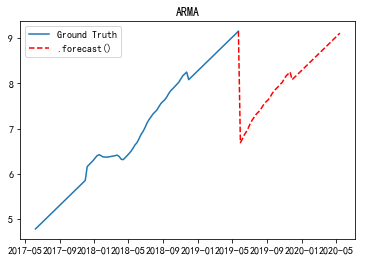

In [43]:
# forecast and predict are different for ARMA
print()
plt.plot(trend, label='Ground Truth')
plt.plot(linear_predict['Predictions'], color='red', label='.forecast()',linestyle='dashed')
plt.legend(loc='best')
plt.title('ARMA')
plt.show()

In [44]:
# predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

In [45]:
# residual_coefficient=proper_model(residual,20)
# print(residual_coefficient)

In [46]:
residual_model =  compare_ARIMA_modes(residual,(18, 1, 8))

C:\ProgramData\Anaconda3\envs\p36workshop\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\envs\p36workshop\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


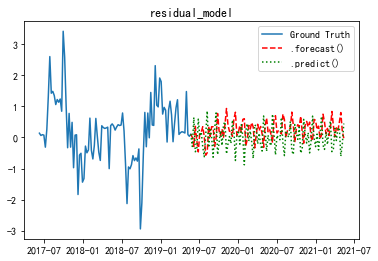

In [47]:
plt.plot(residual, label='Ground Truth')
plt.plot(residual_model['Predictions forecast'], color='red', label='.forecast()',linestyle='dashed')
plt.plot(residual_model['Predictions predict'], color='green', label='.predict()',linestyle='dotted')
plt.legend(loc='best')
plt.title('residual_model')
plt.show(block=False)

In [48]:
seasonal_f=season_forcast_year(seasonal)

In [49]:
forcast_model = linear_predict['Predictions'][1:-1]+2.5+residual_model['Predictions forecast']+seasonal_f
forcast_model.fillna(11.578118,inplace=True)
forcast_model.head()

2019-05-23    11.578118
2019-05-30    11.578118
2019-06-06     9.305397
2019-06-13    10.076639
2019-06-20     9.615748
dtype: float64

In [50]:
forcast_model_least=linear_predict['Predictions'][1:-1]+2.5+seasonal_f
#forcast_model_least.fillna(11.578118,inplace=True)
forcast_model.head()

2019-05-23    11.578118
2019-05-30    11.578118
2019-06-06     9.305397
2019-06-13    10.076639
2019-06-20     9.615748
dtype: float64

# 预测

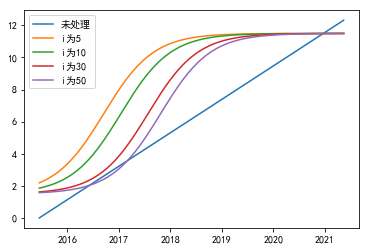

In [51]:
import math
ts_past_list = (ts.index-timedelta(weeks=103)).to_list()
ts_later_list = (ts.index+timedelta(weeks=103)).to_list()
ts_list = ts.index.to_list()
ts_list=ts_past_list+ts_list+ts_later_list
series=pd.Series(np.arange(0, 12.36, 0.04),index=ts_list)
plt.plot(series,label='未处理')
plt.legend(loc='best')
for i in [5,10,30,50]:
    series_p=series.apply(lambda x:10/(1+i*math.e**(1-x))+1.5)
    plt.plot(series_p,label='i为'+str(i))
    plt.legend(loc='best')

In [52]:
print(type(ts.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


C:\ProgramData\Anaconda3\envs\p36workshop\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


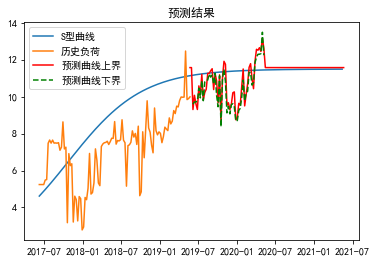

In [53]:
plt.plot(series_p.loc[pd.concat([ts.index.to_series(),forcast_model.index.to_series()]).index],label='S型曲线')
plt.plot(ts, label='历史负荷')
plt.plot(forcast_model, color='red', label='预测曲线上界')
plt.plot(forcast_model_least, color='green', label='预测曲线下界',linestyle='dashed')
plt.legend(loc='best')
plt.title('预测结果')
plt.savefig('foo.png')
plt.show()

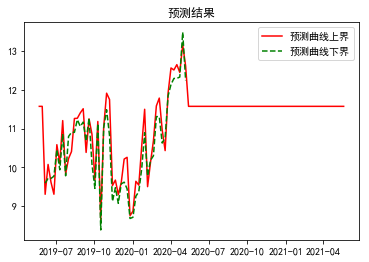

In [54]:
plt.plot(forcast_model, color='red', label='预测曲线上界')
plt.plot(forcast_model_least, color='green', label='预测曲线下界',linestyle='dashed')
plt.legend(loc='best')
plt.title('预测结果')
plt.savefig('foo.png')
plt.show()

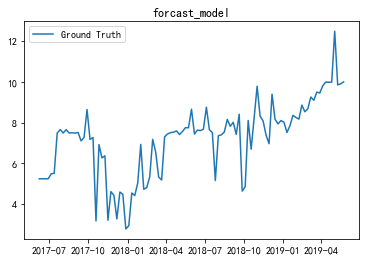

In [55]:
plt.plot(ts, label='Ground Truth')

plt.legend(loc='best')
plt.title('forcast_model')
plt.show()

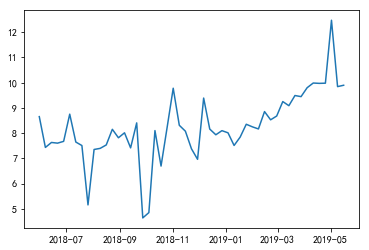

In [56]:
plt.plot(ts[-52:-1])

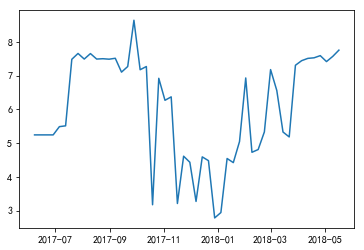

In [57]:
plt.plot(ts[-104:-53])

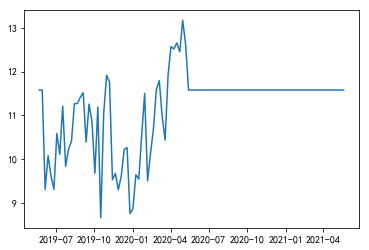

In [58]:
plt.plot(forcast_model)

# 预测时间序列

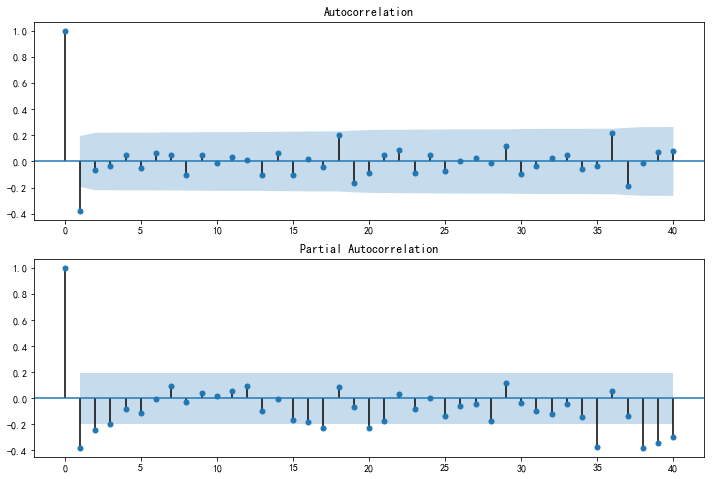

In [59]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff, lags=40, ax=ax1) #从13开始是因为做季节性差分时window是12
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff, lags=40, ax=ax2)

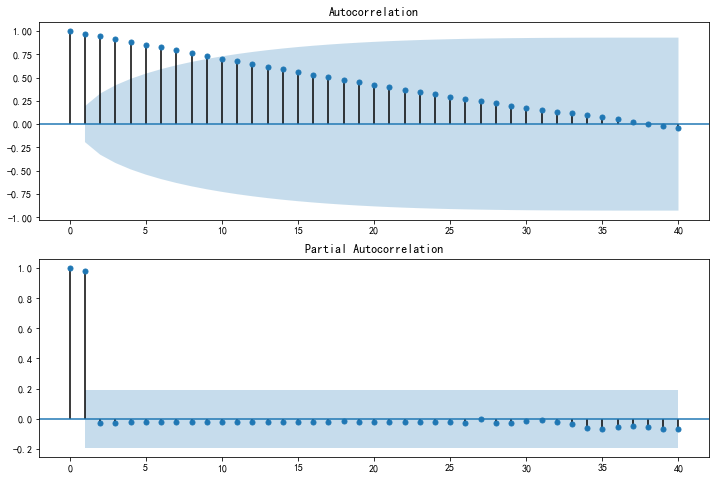

In [60]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend.dropna(), lags=40, ax=ax1) #从13开始是因为做季节性差分时window是12
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend.dropna(), lags=40, ax=ax2)

### ACF & PACF Plots

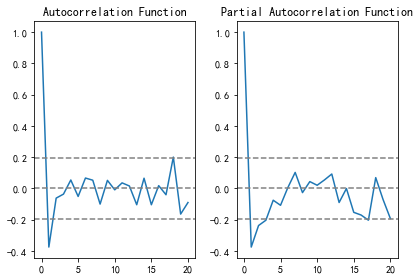

In [61]:
#选择差分处理后的结果进行预测
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#两条虚线之间是置信区间

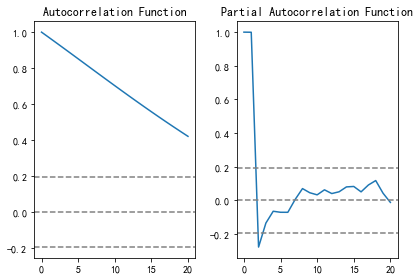

In [62]:
#选择季节分解后的趋势进行预测
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(trend.dropna(), nlags=20)
lag_pacf = pacf(trend.dropna(), nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(trend.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(trend.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(trend.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(trend.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#两条虚线之间是置信区间

### AR Model:

In [63]:
#MA model:
model = ARIMA(ts_log, order=(1, 1, 2),freq=ts_log.index.inferred_freq)  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

NameError: name 'ts_log' is not defined

### MA Model

In [ ]:
model = ARIMA(ts_log, order=(0, 1, 2),freq=ts_log.index.inferred_freq)  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### ARIMA Model:

In [ ]:
model = ARIMA(ts_log, order=(2, 1, 2),freq=ts_log.index.inferred_freq)  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

### 预测还原:

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

In [ ]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

In [ ]:
plt.plot(ts_log)
plt.plot(predictions_ARIMA_diff_cumsum)

In [ ]:
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)
predictions_ARIMA_log=predictions_ARIMA_log.rename('predictions_ARIMA_log')
predictions_ARIMA_log.to_csv(predictions_ARIMA_log.name+'.csv',header=True)

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

### 对分解出来的趋势进行预测